In [22]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')
sns.set(font_scale=1.5)

data_dir = r'C:\Users\James\toronto-open-data-portal'

nbrhood_shp_path = os.path.join(data_dir, 'toronto-nbrhoods-wgs84', 'Neighbourhoods.shp')

#nbrhood_covid_count_path = os.path.join(data_dir, 'toronto-covid-nbrhood-count-060620.csv')
#nbrhood_covid_count_path = os.path.join(data_dir, 'toronto-covid-nbrhood-count-060820.csv')
#nbrhood_covid_count_path = os.path.join(data_dir, 'toronto-covid-nbrhood-count-061520.csv')
nbrhood_covid_count_path = os.path.join(data_dir, 'toronto-covid-nbrhood-count-062220.csv')


## Loading COVID-19 Case Data

**Covid19 Counts per Neighbourhood:** number of cases in each of the 140 Toronto Social Planning Neighbourhoods. Downloaded on [DATE INFO] from https://www.toronto.ca/home/covid-19/covid-19-latest-city-of-toronto-news/covid-19-status-of-cases-in-toronto/

In [23]:
covid_counts = pd.read_csv(nbrhood_covid_count_path, encoding='ISO-8859-1')
covid_counts.head()

,Neighbourhood Name,Case Count,"Rate per 100,000 people"
0,Eglinton East,89,390.762206
1,Don Valley Village,59,218.106539
2,Lansing-Westgate,25,154.664687
3,Edenbridge-Humber Valley,88,566.462826
4,Flemingdon Park,116,528.883418


In [24]:
# The covid data contains a record of counts for missing addresses/postal codes
covid_counts.sort_values(by='Case Count', ascending=False)

,Neighbourhood Name,Case Count,"Rate per 100,000 people"
140,Missing Address/Postal Code,684,NaN
84,Glenfield-Jane Heights,460,1508.641894
76,West Humber-Clairville,437,1311.839577
65,Mount Olive-Silverstone-Jamestown,434,1316.987316
21,Downsview-Roding-CFB,406,1158.279128
...,...,...,...
120,The Beaches,15,69.550702
85,Danforth,13,134.492034
24,Yonge-Eglinton,13,110.011001
108,Blake-Jones,12,155.299599


## Loading Toronto Map Data

In [25]:
nbrhood_geo_data = gpd.read_file(nbrhood_shp_path)
nbrhood_geo_cols = pd.read_csv(os.path.join(data_dir, 'toronto-nbrhoods-wgs84',
                                           'Neighbourhoods_fields.csv'), encoding='ISO-8859-1')

print(nbrhood_geo_data.crs)

epsg:4326


In [26]:
nbrhood_geo_data = nbrhood_geo_data.to_crs({'init':'epsg:3161'})

C:\anaconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [27]:
nbrhood_geo_data.rename(columns=dict(zip(nbrhood_geo_cols.field, nbrhood_geo_cols.name)), inplace=True)

In [28]:
nbrhood_geo_data.head(3)

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,5601,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"POLYGON ((1378793.759 11912529.906, 1378872.56..."
1,5602,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"POLYGON ((1380607.203 11915332.523, 1380712.43..."
2,5603,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),None,None,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"POLYGON ((1382386.717 11912898.538, 1382370.67..."


In [29]:
# remove the area code and trailing whitespace from the area names
nbrhood_geo_data['AREA_NAME'] = nbrhood_geo_data.AREA_NAME.str.replace('\s\(\d+\)', '')

In [30]:
set(nbrhood_geo_data.AREA_NAME).difference(set(covid_counts['Neighbourhood Name']))

{'Briar Hill-Belgravia',
 'Cabbagetown-South St.James Town',
 'Danforth East York',
 'North St.James Town'}

In [31]:
# identified differences in the covid nbrhood names using Pandas' dataframe.col.str.extractall(REGEX) function
covid_counts.loc[[50, 120, 110, 124]]

,Neighbourhood Name,Case Count,"Rate per 100,000 people"
50,Birchcliffe-Cliffside,176,789.556323
120,The Beaches,15,69.550702
110,Briar Hill - Belgravia,85,596.198359
124,East End-Danforth,23,107.572144


In [32]:
# renaming the neighbourhood names in the covid data to the Toronto shapefile conventions
covid_counts.loc[50, 'Neighbourhood Name'] = 'North St.James Town'
covid_counts.loc[120, 'Neighbourhood Name'] = 'Cabbagetown-South St.James Town'
covid_counts.loc[110, 'Neighbourhood Name'] = 'Danforth East York'
covid_counts.loc[124, 'Neighbourhood Name'] = 'Briar Hill-Belgravia'

In [33]:
covid_counts.rename(columns={'Neighbourhood Name':'AREA_NAME'}, inplace=True)

In [34]:
covid_counts.set_index('AREA_NAME', inplace=True)
nbrhood_geo_data.set_index('AREA_NAME', inplace=True)

## Proportional Symbol Map of COVID-19 Cases

1. Create a new GeoSeries from the centroids of the neighbourhood polygons
2. Join the new GeoSeries with the Case Count data
3. Define the size of the markers from the number of cases per neighbourhood
4. Plot both GeoPandas objects in the same matplotlib axis

In [35]:
nbrhood_centroids = gpd.GeoDataFrame(nbrhood_geo_data.centroid, columns=['geometry'])
nbrhood_centroids = nbrhood_centroids.join(covid_counts)

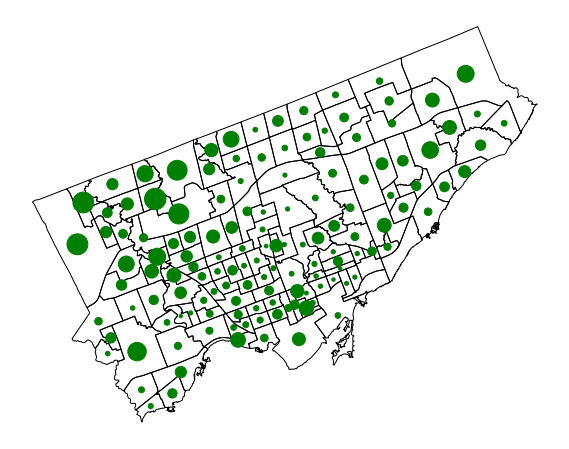

In [50]:
fig, ax = plt.subplots(figsize=(10,8))

ms = nbrhood_centroids['Case Count']

nbrhood_geo_data.plot(ax=ax,
                     facecolor='None',
                     edgecolor='Black')

nbrhood_centroids.plot(ax=ax,
                       markersize=ms,
                       color='green')

ax.set_axis_off()

## Chloropleth Map of COVID-19 Cases

In [46]:
covid_counts.columns

Index(['Case Count', 'Rate per 100,000 people'], dtype='object')

In [39]:
nbrhood_geo_data = nbrhood_geo_data.join(covid_counts)

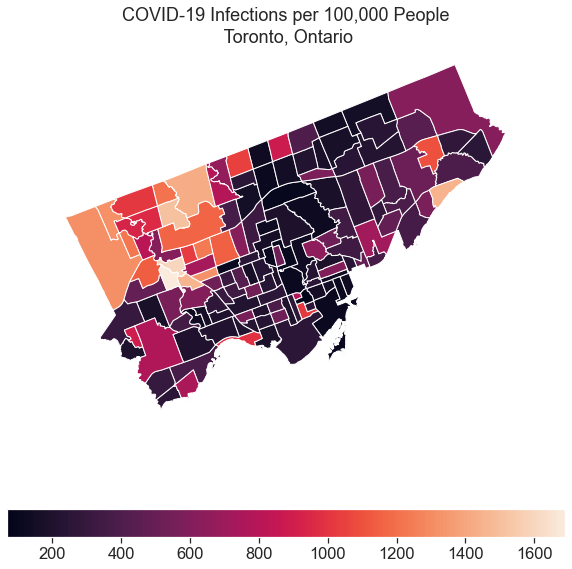

In [54]:
fig, ax = plt.subplots(figsize=(10,10))

nbrhood_geo_data.plot(ax=ax,
                     column='Rate per 100,000 people',
                     legend=True,
                     legend_kwds={'orientation': 'horizontal'})

ax.set_title('COVID-19 Infections per 100,000 People\n Toronto, Ontario')


ax.axis('equal')
ax.set_axis_off()